In [1]:
import pydub
import numpy as np
import matplotlib.pyplot as plt
import os

from dtaidistance import dtw
from scipy.signal import argrelextrema, find_peaks
from scipy.spatial.distance import cosine

import pandas as pd
import seaborn as sns

In [2]:
SOUND_FRAME_RATE=40000

## Playground

In [3]:
def get_audio_sample(sound_addr):
    sound = pydub.AudioSegment.from_file(sound_addr, format=sound_addr.split(".")[-1])
    sound = sound.set_frame_rate(SOUND_FRAME_RATE)
    samples = sound.get_array_of_samples()
    audio_sample = np.array(samples)
    return audio_sample

In [4]:
def get_audio_prompt(sound_addr):
    sound = pydub.AudioSegment.from_file(sound_addr, format=sound_addr.split(".")[-1])
    sound = sound.set_frame_rate(SOUND_FRAME_RATE)
    samples = sound.get_array_of_samples()
    audio_sample = np.array(samples)[int(sound.frame_rate*(4/3)**2*8):]
    return audio_sample

In [11]:
def downsample_signal(signal, block_num):
    resulting_signal = np.zeros(block_num + 1)
    nonzero_indices = np.nonzero(signal)[0] // (len(signal) // block_num)
    resulting_signal[nonzero_indices] = 1
    return resulting_signal

## Scoring Procedure

In [12]:
def master_scoring_procedure(participant_response, answer_addr):
    participant_sample = get_audio_sample(participant_response)
    answer_sample = get_audio_prompt(answer_addr)
    
    participant_signal = np.where(participant_sample > 0.1 * np.max(participant_sample), 1.0, 0)
    participant_nonzero_indices = np.nonzero(participant_signal)[0]
    participant_signal = participant_signal[participant_nonzero_indices[0]:participant_nonzero_indices[-1] + 1]
    
    answer_signal = np.where(answer_sample[:int(44100 * 4/3 * 8)] > 800, 1, 0)
    answer_nonzero_indices = np.nonzero(answer_signal)[0]
    answer_signal = answer_signal[answer_nonzero_indices[0]:answer_nonzero_indices[-1] + 1]
    
    participant_downsample = downsample_signal(participant_signal, 100)
    true_sample_downsample = downsample_signal(answer_signal, 100)
    return cosine(participant_downsample, true_sample_downsample)

In [13]:
all_participants = os.listdir("./participant_data/")
scoring_basis_files = [
    f"../generated_beats/compiled_mp3/{file_name}"
    for file_name in os.listdir("../generated_beats/compiled_mp3/")
    if "practice" not in file_name
]
full_scoring_data = {
    "trial_source": [],
    "signal_similarities": [],
    "participant_ID": []
}
for participant in all_participants[:]:
    if participant == "22-J-13-SUR": continue
    participant_response_addresses = {
        file_name.split(".")[0]: f"./participant_data/{participant}/{file_name}"
        for file_name in os.listdir(f"./participant_data/{participant}/")
    }
    scoring_file_addresses = {
        "night_1_trial_1": scoring_basis_files[9],
        "night_1_trial_2": scoring_basis_files[10],
        "night_1_trial_3": scoring_basis_files[11],
        "night_2_trial_1": scoring_basis_files[12],
        "night_2_trial_2": scoring_basis_files[13],
        "night_2_trial_3": scoring_basis_files[14],
        "night_3_trial_1": scoring_basis_files[15],
        "night_3_trial_2": scoring_basis_files[16],
        "night_3_trial_3": scoring_basis_files[17],
        "morning_2_trial_1": scoring_basis_files[3],
        "morning_2_trial_2": scoring_basis_files[4],
        "morning_2_trial_3": scoring_basis_files[5],
        "morning_3_trial_1": scoring_basis_files[6],
        "morning_3_trial_2": scoring_basis_files[7],
        "morning_3_trial_3": scoring_basis_files[8]
    }
    if "morning_1" in list(participant_response_addresses.keys())[0]:
        participant_response_addresses.update(
            {
                "morning_2_trial_1": participant_response_addresses.pop("morning_1_trial_1"),
                "morning_2_trial_2": participant_response_addresses.pop("morning_1_trial_2"),
                "morning_2_trial_3": participant_response_addresses.pop("morning_1_trial_3"),
                "morning_3_trial_1": participant_response_addresses["morning_2_trial_1"],
                "morning_3_trial_2": participant_response_addresses["morning_2_trial_2"],
                "morning_3_trial_3": participant_response_addresses["morning_2_trial_3"]
            }
        )
        scoring_file_addresses.update(
            {
                "morning_2_trial_1": scoring_basis_files[0],
                "morning_2_trial_2": scoring_basis_files[1],
                "morning_2_trial_3": scoring_basis_files[2],
                "morning_3_trial_1": scoring_basis_files[3],
                "morning_3_trial_2": scoring_basis_files[4],
                "morning_3_trial_3": scoring_basis_files[5]
            }
        )
    for trial_source in participant_response_addresses.keys():
        full_scoring_data["participant_ID"].append(participant)
        full_scoring_data["trial_source"].append(trial_source)
        full_scoring_data["signal_similarities"].append(
            master_scoring_procedure(
                participant_response_addresses[trial_source],
                scoring_file_addresses[trial_source]
            )
        )

## Analysis Stage

In [61]:
everyone_score = pd.DataFrame(data=full_scoring_data)
everyone_score["trial_source_abbrev"] = everyone_score["trial_source"].apply(lambda x: x.split("_trial")[0])
PSQI_responses = pd.read_csv("../PSQI/exported-PSQI.csv")
everyone_score_With_PSQI = everyone_score.merge(
    right=PSQI_responses,
    left_on="participant_ID",
    right_on="participant_ID"
).query("trial_source_abbrev=='morning_2'")
everyone_score_With_PSQI = everyone_score_With_PSQI.drop(
    columns=["trial_source", "trial_source_abbrev", "participant_ID", "Unnamed: 0"]
)
everyone_score_With_PSQI = everyone_score_With_PSQI + np.random.normal(0, 0.01, everyone_score_With_PSQI.shape)
everyone_score_With_PSQI.head()

,signal_similarities,c1,c2,c3,c4,c5,c6,c7,PSQI
0,0.716062,0.017207,3.004209,0.002463,3.001978,3.005502,-0.005067,1.016783,10.001994
1,0.445616,-0.018896,2.995264,-0.004434,2.987354,2.998877,0.001247,1.006047,9.989638
2,0.805749,0.015305,2.988332,0.013694,2.995816,2.990905,0.007260,1.000869,10.010227
15,0.825086,0.978879,0.994964,1.013988,2.995684,2.995586,0.009917,1.018896,9.980120
16,0.815175,1.000189,0.995119,1.010713,3.004663,3.004497,-0.004430,1.014929,9.995760


Text(0.5, 1.0, 'Correlation Matrix between PSQI Subcomponent Scores on Form B with Rhythm Task Performance on Morning 2')

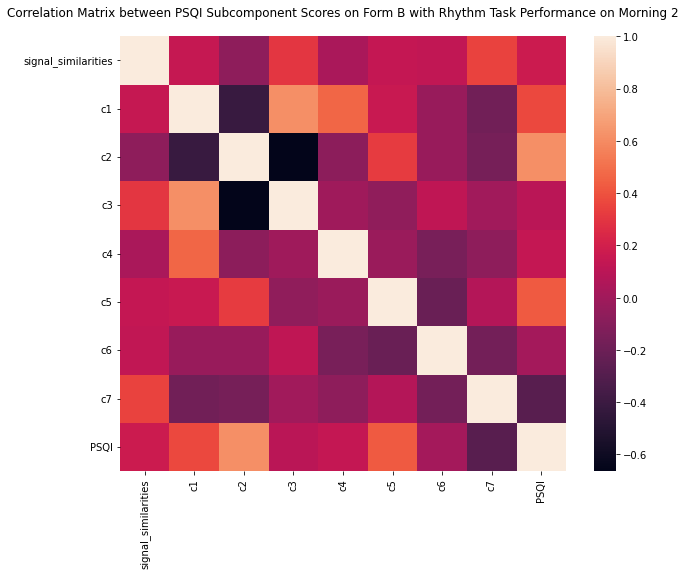

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    everyone_score_With_PSQI.corr()
)
plt_title = "Correlation Matrix between PSQI Subcomponent Scores on Form B with Rhythm Task Performance on Morning 2"
ax.set_title(plt_title, pad=20)

Text(0, 0.5, 'Cosine Similarity of Prompt and Participant Response')

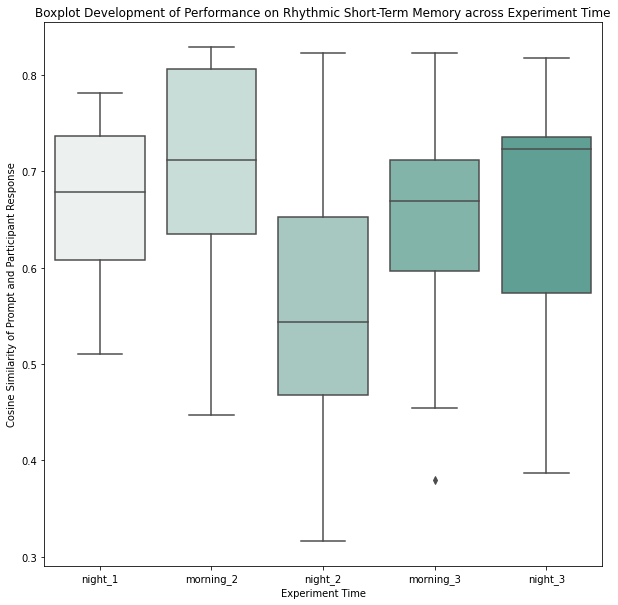

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(
    data=everyone_score,
    x="trial_source_abbrev",
    y="signal_similarities",
    order=["night_1", "morning_2", "night_2", "morning_3", "night_3"],
    palette="light:#5A9"
)
plt.title("Boxplot Development of Performance on Rhythmic Short-Term Memory across Experiment Time")
plt.xlabel("Experiment Time")
plt.ylabel("Cosine Similarity of Prompt and Participant Response")